/tritonhomes/laurynas/DepthRegularizedGS/cam.py:93: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/Cross.cpp:63.)
  x = normalize(torch.cross(up, z))


5.465222448353519


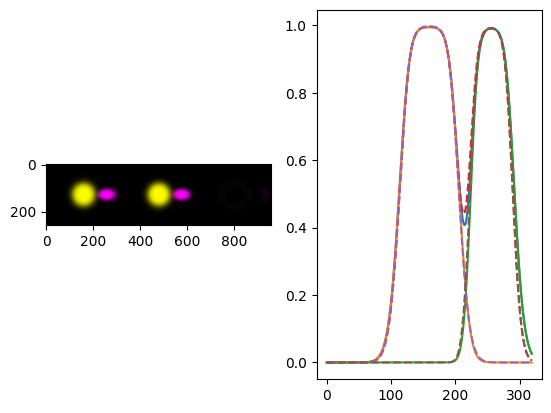

In [1]:
import torch
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FFMpegWriter
import os
import cam

torch.set_default_dtype(torch.float64)

W, H = 32, 25
W, H = 320, 256
N = 1000
# num_frames = 128
num_frames = 2
fov = torch.pi / 2
near = -1
far = -10
# theta = torch.pi / 4
theta = 0

camera = cam.make_opengl_camera_from_fov(W, H, fov, near, far)

# index = torch.tensor([(W - 1) / 2, (H - 1) / 2])
# u = cam.pixel_index_to_coord(index)
# p1, p2 = cam.pixel_index_to_ray(index)

gaussians = [
    cam.Gaussian(
        torch.tensor([1, 1, 0]),
        10,
        torch.tensor([0, 0, 0]),
        0.5 * torch.diag(torch.tensor([1, 1, 0.1])),
    ),
    cam.Gaussian(
        torch.tensor([1, 0, 1]),
        5,
        torch.tensor([-3, 0, 0]),
        0.5 * torch.diag(torch.tensor([0.5, 0.25, 0.25])),
    ),
]

fps = int(min(30, max(num_frames / 5, 1)))
writer = FFMpegWriter(fps=fps)
fig = plt.figure()

E = []
movie_path = os.path.join(os.path.expanduser("~"), "Desktop", "gaussians.mp4")
movie_path = os.getcwd() + "/gaussians.mp4"
with writer.saving(fig, movie_path, 100):
    for theta in torch.linspace(0, 2 * torch.pi, num_frames + 1)[:-1]:
        camera.look_at(
            eye=5 * torch.tensor([math.sin(theta), 0, math.cos(theta)]),
            center=torch.tensor([0, 0, 0]),
            up=torch.tensor([0, 1, 0]),
        )
        image = cam.render(camera, gaussians)

        gaussians_ = [cam.project_gaussian(camera, g) for g in gaussians]
        image_ = cam.render25D(camera, gaussians_)

        E.append(torch.norm(image - image_).item())

        im1 = image.permute(1, 2, 0).numpy()
        im2 = image_.permute(1, 2, 0).numpy()

        plt.clf()
        plt.subplot(1, 2, 1)
        plt.imshow(np.concatenate((im1, im2, np.abs(im1 - im2)), axis=1), clim=(0, 1))

        plt.subplot(1, 2, 2)
        plt.plot(im1[camera.H // 2, :, :].squeeze())
        plt.plot(im2[camera.H // 2, :, :].squeeze(), "--")
        writer.grab_frame()

print(torch.tensor(E).mean().item())

# Normalized: 2.5653654790215974
# Not normalized: 4.289070104995401

# print(cam.K)
# print(cam.P)
# print(cam.Q)
# print(u)
# print(p1, p2)

before background fixup tensor(1.0191)
after background fixup tensor(1.0191)


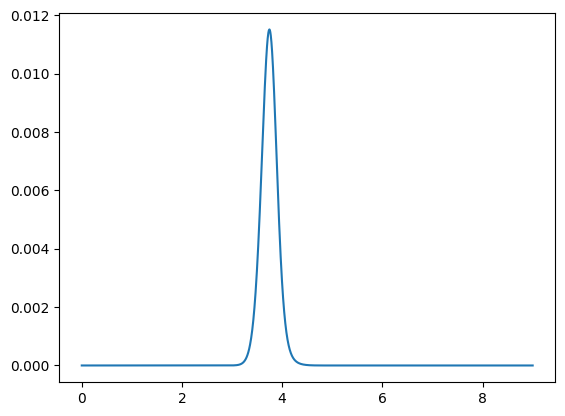

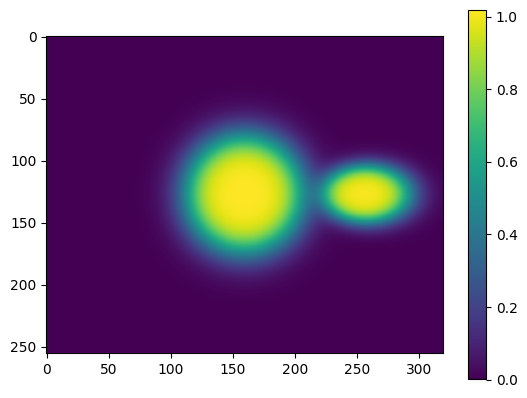

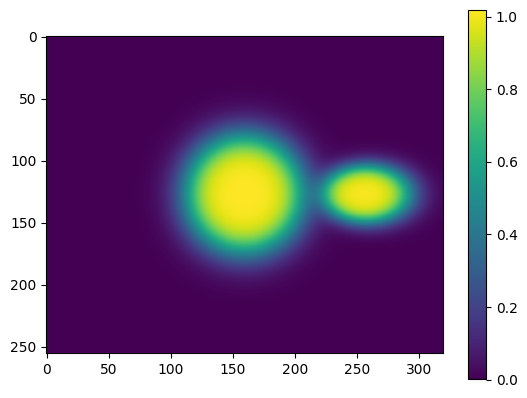

In [4]:
dist_p, dist_v, p1, p2 = cam.get_dist_volume(camera, gaussians, 2048)

# Compute total mass along each ray -- because we do not have a bkg,
# mass is lost where things are not opaque enough
delta = dist_v[1, :, :]
mass = delta * dist_p.sum(0)  # LK: this is p(t)dt
# print(mass.shape)
mass_pre = mass
print("before background fixup", mass.max())

# Fixup by creating a wall at the far distance
# dist_p[-1, :, :] = (1 - mass).clamp(min=0) / delta

# mass = delta * dist_p.sum(0)
print("after background fixup", mass.max())

plt.figure()
uv = dist_p.shape[1]//2, dist_p.shape[2]//2
plt.plot(dist_v[:, *uv].numpy(), delta[*uv] * dist_p[:, *uv].numpy())
# plt.ylim([0, 0.02])

plt.figure()
plt.imshow(mass.numpy())
plt.colorbar()

plt.figure()
plt.imshow(mass_pre.numpy())
plt.colorbar()

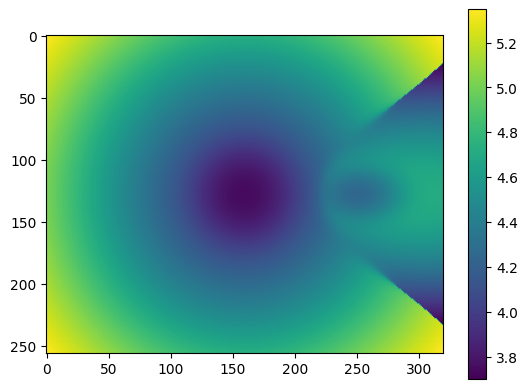

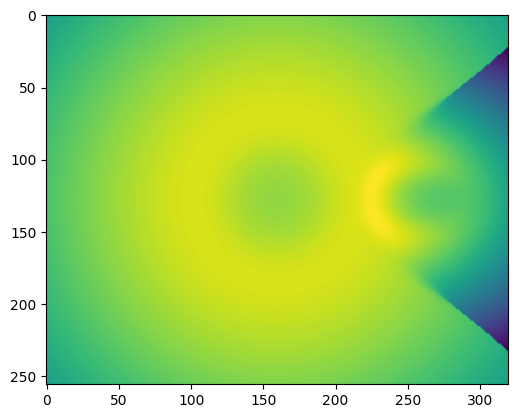

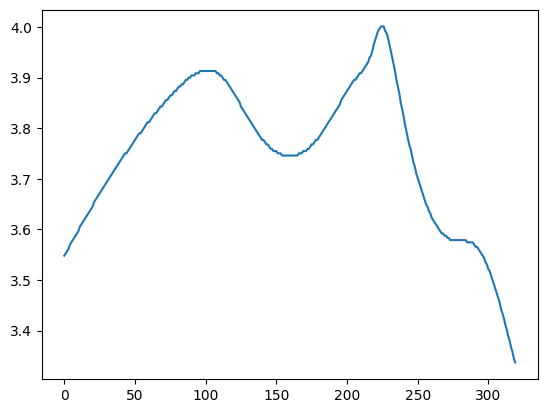

In [7]:
v = (p2 - p1) / (p2 - p1).norm(dim=-1, keepdim=True)
zvec = (p2 - p1).mean(dim=[0,1])
zvec = zvec / zvec.norm()
i = dist_p.argmax(dim=0)
d = torch.gather(input=dist_v, dim=0, index=i.unsqueeze(0))
z = (zvec * v).sum(-1) * d

plt.figure()
plt.imshow(d.squeeze().numpy())
plt.colorbar()

plt.figure()
plt.imshow(z.squeeze().numpy())
# plt.hline(z.shape[1]//2,'.')

plt.figure()
plt.plot(z.squeeze()[z.shape[1]//2,:].numpy())

In [9]:
(dist_p * dist_v).sum(0)

tensor([[3.9246e-12, 4.9368e-12, 6.2041e-12,  ..., 6.2353e-12, 4.9679e-12,
         3.9556e-12],
        [4.7139e-12, 5.9319e-12, 7.4574e-12,  ..., 7.5030e-12, 5.9773e-12,
         4.7590e-12],
        [5.6553e-12, 7.1194e-12, 8.9537e-12,  ..., 9.0204e-12, 7.1857e-12,
         5.7213e-12],
        ...,
        [5.6553e-12, 7.1194e-12, 8.9537e-12,  ..., 9.0204e-12, 7.1857e-12,
         5.7213e-12],
        [4.7139e-12, 5.9319e-12, 7.4574e-12,  ..., 7.5030e-12, 5.9773e-12,
         4.7590e-12],
        [3.9246e-12, 4.9368e-12, 6.2041e-12,  ..., 6.2353e-12, 4.9679e-12,
         3.9556e-12]])